# Introduction

As the demand for computing power in AI workloads continues to surge, while the performance and frequency improvements of individual chips slow down, and the memory walls and bandwidth walls encountered by large models, large graphs, and large tables requiring massive capacity and bandwidth, the hardware is gradually shifting towards a scale-out direction, such as multi-GPU, multi-chip, multi-die, etc. After hardware scales up, the challenges faced by AI software extend from computing distribution within a single node to data distribution across multiple nodes, as well as communication overhead brought by data dependencies.

I believe that the combination of hardware horizontal expansion will become more diverse, and manually building highly optimized kernels for different topological combinations will become more difficult. Therefore, the technology of automatically generating distributed computing kernels through AI compilation will become important.

In this context, I originally intended to try using AI compilation technology to automatically search for kernel implementations that conform to computing and data distribution, but due to current technical limitations, I cannot achieve this yet. Therefore, I take a step back and attempt to model distributed computing using polyhedral compilation, analyze and filter out legal implementations to lay the foundation for future automation. In short, this article adopts the Compute Schedule separation approach, combined with polyhedral technology, to build a fusion DSL that can help everyone better understand the relationship between computing distribution and data distribution, and also serves as a more comprehensive usage example of polyhedral compilation technology.

Notes:

1. This article draws heavily on inspiration from the [Distal paper](https://arxiv.org/abs/2203.08069); please refer to [here](https://zhen8838.github.io/2025/02/04/distal/) for supplementary background knowledge. Distal is actually based on the long-developed Legion project, where Legion implements a domain/point-based polyhedral mapping scheme in the runtime, allowing relatively simple implementation of various forms of communication. This article, for minimal dependencies, uses polyhedral analysis to identify communication patterns and offloads them to the MPI backend, which is the main difference.
2. If there is a backend like SymmetricMemory, it can simplify complex communication pattern detection.
3. This article currently only implements code generation for a single-level topology; adaptation for multi-level topologies still needs further exploration.
4. This article implements compute-communication fusion; for the need to overlap communication and computation, it is necessary to switch to a backend that supports asynchronous communication, and to implement it with optimizations like NBuffer/SoftPipeline compilation.

# Implementation

In [1]:
from abc import abstractmethod
from typing import Tuple, Union, TextIO, List, Dict, Optional, Any, Callable, Sequence, cast, NamedTuple

from io import FileIO
from dataclasses import dataclass, replace, field
from functools import reduce
from itertools import chain
import more_itertools as itertools
from enum import IntEnum
from xdsl.dialects import arith, builtin, tensor, linalg, func
from xdsl.frontend.pyast.context import PyASTContext, TypeRegistry
from xdsl.frontend.pyast.code_generation import CodeGeneration, CodeGenerationVisitor
from xdsl import ir
from xdsl.irdl import irdl_op_definition, IRDLOperation, prop_def, result_def, operand_def, var_operand_def, attr_def
from xdsl import passes
import dowhen
import isl

To implement a more complete DSL, a frontend is essential. Fortunately, [xDSL](https://github.com/xdslproject/xdsl) recently provided a simplified frontend [xDSL front-end: Embedding MLIR into Python](https://github.com/xdslproject/xdsl/tree/v0.48.3/xdsl/frontend/pyast). Although it has many imperfections, in Python, we can use the [dowhen](https://github.com/gaogaotiantian/dowhen) library to monkey-patch xDSL to supplement the imperfections.

The logic of xDSL is to bridge Python types and MLIR types through `TypeRegistry`, and then traverse and generate using the pre-provided `CodeGenerationVisitor`. However, it currently does not support type annotations with parameters, such as `Buffer[float, [2048, 1024]]`. I solved this with a custom `ParameterizedTypeRegistry`. Additionally, the default `CodeGenerationVisitor` does not support some AST visits, which I supplemented with `MyCodeGenVisitor`. After extending these implementations, by using the `dowhen` library to replace some internal calls in xDSL, I successfully built a frontend based on index notation.

In [2]:

class ParameterizedTypeRegistry(TypeRegistry):
  def __init__(self):
    super().__init__()
    self._generic_mapping: dict[type, type] = {}

  def resolve_attribute(
      self, annotation_name: str, globals: dict[str, Any]
  ) -> ir.TypeAttribute | None:
    """Get an IR type attribute from a string annotation."""
    annotation = cast(
        type,
        eval(annotation_name, globals, None),
    )
    if isinstance(annotation, ir.TypeAttribute):
      return annotation
    return self._mapping.get(annotation, None)

  def get_annotation(self, attribute: ir.TypeAttribute) -> type | None:
    anno = super().get_annotation(attribute)
    if anno is None:
      for key, value in self._generic_mapping.items():
        if value == type(attribute):
          return key
    return anno

  def register_param_type(self, annotation: type,
                          attributeType: type):
    self._generic_mapping[annotation] = attributeType


class MyCodeGenVisitor(CodeGenerationVisitor):
  def parse_op(self, ir_type, func_name, args: tuple):
    ir_type = cast(ir.TypeAttribute, ir_type)
    source_type = self.type_converter.type_registry.get_annotation(ir_type)
    assert source_type
    function_name = f"{source_type.__qualname__}.{func_name}"
    op = self.type_converter.function_registry.resolve_operation(
        module_name=source_type.__module__,
        method_name=function_name,
        args=args,
    )
    assert op
    self.inserter.insert_op(op)

  def visit_Subscript(self, node):
    self.visit(node.slice)
    elts = [self.inserter.get_operand() for i in range(len(node.slice.elts))]
    self.visit(node.value)
    value = self.inserter.get_operand()
    self.parse_op(value.type, '__getitem__', (value, elts[::-1]))

  def visit_Tuple(self, node):
    for elt in node.elts:
      self.visit(elt)

  def visit_Assign(self, node) -> None:
    self.visit(node.targets[0])
    target = self.inserter.get_operand()
    self.visit(node.value)
    value = self.inserter.get_operand()
    self.inserter.insert_op(AssignOp(target, value))


dowhen.when(CodeGeneration.run_with_type_converter, "+9").do(
    lambda type_converter, module, file:
    {"visitor": MyCodeGenVisitor(type_converter, module, file)})


class IterKind(IntEnum):
  Serial = 0
  Distributed = 1
  Tensorize = 2


class UsageKind(IntEnum):
  Input = 0
  Output = 1
  Const = 2


@dataclass(frozen=True)
class Expr:

  def __add__(self, other: 'Expr') -> 'Expr':
    return Binary.create('+', self, other)

  def __sub__(self, other: 'Expr') -> 'Expr':
    return Binary.create('-', self, other)

  def __mul__(self, other: 'Expr') -> 'Expr':
    return Binary.create('*', self, other)

  def __floordiv__(self, other: 'Expr') -> 'Expr':
    return Binary.create('//', self, other)

  def __truediv__(self, other: 'Expr') -> 'Expr':
    return Binary.create('/', self, other)

  def __mod__(self, other: 'Expr') -> 'Expr':
    return Binary.create('%', self, other)

  @abstractmethod
  def walk(fn: Callable[['Expr'], None]):
    pass


@dataclass(frozen=True)
class Const(Expr):
  value: int

  def __str__(self):
    return str(self.value)

  def walk(self, fn: Callable[['Expr'], None]):
    fn(self)


@dataclass(frozen=True)
class IterVar(Expr):
  name: str
  lower_bound: int | None
  upper_bound: int | None
  step: int = 1

  @property
  def extent(self) -> int:
    return self.upper_bound - self.lower_bound

  @staticmethod
  def range(name: str, extent: int):
    return IterVar(name, 0, extent, 1)

  @staticmethod
  def symbol(name: str):
    vars = tuple(map(lambda s: IterVar(s, None, None, 1), name.split(' ')))
    return vars[0] if len(vars) == 1 else vars

  def __hash__(self):
    return hash((self.name, self.lower_bound, self.upper_bound, self.step))

  def __str__(self):
    return self.name

  def walk(self, fn: Callable[['Expr'], None]):
    fn(self)


@dataclass(frozen=True)
class Binary(Expr):
  op: str
  lhs: Expr
  rhs: Expr

  @staticmethod
  def create(op: str, lhs: Expr, rhs: Expr):
    match lhs:
      case int():
        lhs = Const(lhs)
      case Expr():
        pass
      case _:
        raise TypeError(f"Unsupported left-hand side operand type: {type(lhs)}")
    match rhs:
      case int():
        rhs = Const(rhs)
      case Expr():
        pass
      case _:
        raise TypeError(f"Unsupported right-hand side operand type: {type(rhs)}")

    return Binary(op=op, lhs=lhs, rhs=rhs)

  def __str__(self):
    return f"({self.lhs} {self.op} {self.rhs})"

  def walk(self, fn: Callable[['Expr'], None]):
    self.lhs.walk(fn)
    self.rhs.walk(fn)
    fn(self)


@dataclass(frozen=True)
class Buffer:
  name: str
  dims: tuple[int | IterVar, ...]
  dtype: type = float
  sharding: None | isl.map = None
  usage: UsageKind = UsageKind.Input

  @property
  def shape(self) -> tuple[int | IterVar, ...]:
    return tuple(d for d in self.dims)

  @property
  def domain(self) -> isl.set:
    def render(i): return f'0 <= d{i} < {self.dims[i]}' if isinstance(
        self.dims[i], int) else f'{self.dims[i].lower_bound} <= d{i} < {self.dims[i].upper_bound}'
    return isl.set(f"{{ {self.name}[{','.join([f'd{i}' for i in range(len(self.dims))])}] : {' and '.join([render(i) for i in range(len(self.dims))])} }}")

  def __hash__(self):
    return hash((self.name, self.dims, self.dtype, str(self.sharding)))

  @classmethod
  def __class_getitem__(cls, args):
    elem_type = None
    if issubclass(args[0], float):
      elem_type = builtin.f32
    elif issubclass(args[0], int):
      elem_type = builtin.i32
    else:
      raise TypeError(f"Unsupported element type: {args[0]}")
    return builtin.MemRefType(elem_type, [builtin.IntAttr(arg) for arg in args[1]])

  def __setitem__(cls, args):
    raise NotImplementedError()

  def __getitem__(cls, args):
    raise NotImplementedError()

  def __iadd__(self, value):
    raise NotImplementedError()

  def __matmul__(self, value):
    raise NotImplementedError()


@irdl_op_definition
class AccessOp(IRDLOperation):
  name = "buffer.access"

  buffer = operand_def(builtin.MemRefType)
  indices = var_operand_def(builtin.IndexType)
  result = result_def(builtin.Attribute)

  def __init__(
      self,
      buffer: ir.SSAValue,
      indices: Sequence[ir.SSAValue] | ir.SSAValue,
      result_type: ir.Attribute,
  ):
    return super().__init__(operands=[buffer, indices], result_types=[result_type])


@irdl_op_definition
class AssignOp(IRDLOperation):
  name = "tensor.assign"

  target = operand_def(ir.TypeAttribute)
  value = operand_def(ir.TypeAttribute)

  def __init__(
      self,
      target: ir.SSAValue,
      value: ir.SSAValue,
  ):
    return super().__init__(operands=[target, value],
                            result_types=[])


type_registry = ParameterizedTypeRegistry()
type_registry.register_param_type(Buffer, builtin.MemRefType)
ctx = PyASTContext(type_registry)
ctx.register_type(float, builtin.f32)
ctx.register_type(IterVar, builtin.IndexType())
ctx.register_function(Buffer.__getitem__, lambda *args:
                      AccessOp(args[0], args[1], args[0].type.element_type))
ctx.register_function(Buffer.__setitem__, lambda *args:
                      AssignOp(args[0], args[1]))
ctx.register_function(float.__mul__, arith.MulfOp)


@ctx.parse_program
def matmul(A: Buffer[float, [512, 2048]], B: Buffer[float, [2048, 1024]], C: Buffer[float, [512, 1024]], m: IterVar, n: IterVar, k: IterVar) -> Buffer[float, [512, 1024]]:
  C[m, n] = A[m, k] * B[k, n]
  return C


print(matmul.module)

builtin.module {
  func.func @matmul(%A : memref<512x2048xf32>, %B : memref<2048x1024xf32>, %C : memref<512x1024xf32>, %m : index, %n : index, %k : index) -> memref<512x1024xf32> {
    %0 = "buffer.access"(%C, %m, %n) : (memref<512x1024xf32>, index, index) -> f32
    %1 = "buffer.access"(%B, %k, %n) : (memref<2048x1024xf32>, index, index) -> f32
    %2 = "buffer.access"(%A, %m, %k) : (memref<512x2048xf32>, index, index) -> f32
    %3 = arith.mulf %2, %1 : f32
    "tensor.assign"(%0, %3) : (f32, f32) -> ()
    func.return %C : memref<512x1024xf32>
  }
}


Since I tend to use a polyhedral approach for compiler optimization, I still need my own IR. In the previous step, I defined expressions such as `Expr`, `Const`, `IterVar`, and `Binary`. Here, I also need to define other core components, such as `Computation` which represents a specific computation, `Mesh` which represents topology, `Access` which represents the access information of computations to `Buffer`, and `Transfer` which represents data movement information.

In [3]:

@dataclass(frozen=True)
class Mesh:
  dims: tuple[IterVar, ...]

  @property
  def shape(self) -> tuple[int, ...]:
    return tuple(var.extent for var in self.dims)

  @property
  def domain(self) -> isl.set:
    return isl.set(f"{{ Mesh[{','.join(map(str, self.dims))}] : {' and '.join([f'{dim.lower_bound} <= {dim} < {dim.upper_bound}' for dim in self.dims])} }}")


@dataclass(frozen=True)
class Access:
  buffer: Buffer
  relation: isl.map

  def __hash__(self):
    return hash((self.buffer, str(self.relation)))

@dataclass(frozen=True)
class Transfer:
  access: Access
  schedule: isl.map

class AccessDimIndex(NamedTuple):
  access_idx: int
  buffer_dim: int

@dataclass(frozen=True)
class Computation:
  op: str
  domain: isl.set
  schedule: isl.map
  accesses: List[Access]
  iter_vars: tuple[IterVar]
  mesh: Mesh | None = None
  iter_kinds: dict[IterVar, IterKind] = field(default_factory=dict)
  dim_bindings: dict[int, List[AccessDimIndex]] = field(default_factory=dict)
  transfers: dict[IterVar, Tuple[Transfer, ...]] = field(default_factory=dict)

  def name(self):
    return self.domain.get_tuple_name()

Next, I will parse the AST into my own IR. Here, the parsing of index notation is only implemented in a simple way, that is, the case where iterVar directly participates in buffer access. More complex situations are left for interested readers to implement on their own. The parsing process is also relatively simple: by analyzing the usage of `SSAValue` by `AccessOp`, we can obtain the computed `Domain/AccessRelation/Schedule`, which are then uniformly stored in `Computation`:

In [4]:
class IndexCollector:
  def __init__(self, iter_set: set[IterVar]):
    self.iter_set: set[IterVar] = iter_set

  def collect(self, node: ir.IRWithUses):
    # todo support complex index pattern
    match node:
      case ir.BlockArgument():
        match node.type:
          case builtin.IndexType():
            iter_var = IterVar.symbol(node.name_hint)
            self.iter_set.add(iter_var)
            return iter_var
      case _:
        raise NotImplementedError("Unsupported index node")


class StmtCollector:
  def __init__(self, stmt_name: str):
    self.stmt_name = stmt_name
    self.iter_set: set[IterVar] = set()
    self.access_dict: dict[AccessOp, (Buffer, list[ir.Operation])] = {}
    self.op: str = None
    self.on_value = False

  def visit(self, node: ir.IRWithUses):
    match node:
      case ir.BlockArgument():
        match node.type:
          case builtin.MemRefType():
            return Buffer(node.name_hint, tuple(dim.data for dim in node.type.shape), node.type.element_type, usage=UsageKind.Input if self.on_value else UsageKind.Output)
          case _:
            return
      case ir.SSAValue() | ir.Operation():
        op = node if isinstance(node, ir.Operation) else node.owner
        match op:
          case AssignOp():
            self.on_value = False
            self.visit(op.target)
            self.on_value = True
            self.visit(op.value)
            self.on_value = False
          case AccessOp():
            b: Buffer = self.visit(op.buffer)
            indices = [IndexCollector(self.iter_set).collect(i) for i in op.indices]
            self.access_dict[op] = (b, indices)
          case arith.MulfOp():
            assert self.op is None
            self.op = op.name
            self.visit(op.lhs)
            self.visit(op.rhs)


class PolyhedronExtractPass(passes.ModulePass):
  name = "polyhedron_analysis"

  def __init__(self):
    self.computations: list[Computation] = []
    return super().__init__()

  def analysis_stmt(self, op: AssignOp):
    assert len(self.computations) == 0, "not support stmts more than 1"
    stmt_name = f's{len(self.computations)}'
    c = StmtCollector(stmt_name)
    c.visit(op)
    accesses = []
    iters = sorted(c.iter_set, key=lambda i: i.name)
    domain_dims = list(map(lambda x: x.name, iters))
    domain = isl.set(f"{{ {stmt_name}[{','.join(domain_dims)}] }}")
    bounded_iters: dict[str, IterVar] = {}
    dim_bindings: dict[int, List[Tuple[int, int]]] = {}
    for (bf, indices) in c.access_dict.values():
      relation = isl.map(
          f"{{ {stmt_name}[{','.join(domain_dims)}] -> {bf.name}[{','.join(map(lambda x: x.name, indices))}]}}")
      domain = domain.intersect(relation.intersect_range(bf.domain).domain())
      for i, idx in enumerate(indices):
        if idx.name not in bounded_iters:
          bounded_iters[idx.name] = replace(idx, lower_bound=bf.domain.dim_min_val(
              i).num_si(), upper_bound=bf.domain.dim_max_val(i).num_si() + 1)
      access = Access(replace(bf, dims=tuple(
          [bounded_iters[idx.name] for idx in indices])), relation)
      accesses.append(access)
      for i, idx in enumerate(indices):
        j = iters.index(idx)
        binding = dim_bindings.get(j, [])
        binding.append(AccessDimIndex(len(accesses) - 1, i))
        dim_bindings[j] = binding
        
    comp = Computation(c.op, domain, domain.identity(), accesses,
                       tuple([bounded_iters[v.name] for v in iters]), dim_bindings=dim_bindings)
    self.computations.append(comp)

  def analysis_op(self, op: ir.Operation):
    if isinstance(op, AssignOp):
      self.analysis_stmt(op)

  def apply(self, ctx, op: builtin.ModuleOp) -> dict[str, Computation]:
    for sub in op.walk():
      self.analysis_op(sub)
    return self.computations


def polyhedron_extract(func) -> Computation:
  return PolyhedronExtractPass().apply(passes.Context(allow_unregistered=True), func.module)[0]
  
s0 = polyhedron_extract(matmul)
s0

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[k' = k, m' = m, n' = n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), accesses=[Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Input: 0>), relation=isl.map("{ s0[k, m, n] -> A[m, k] }")), Access(buffer=Buffer(name='B', dims=(IterVar(name='k', lower_bound=0, upper_bound=2048, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKi

The IR I designed is an immutable structure. My idea is to implement a schedule trace similar to [Meta Scheduler](https://arxiv.org/abs/2205.13603), so that it can be connected to external optimizers for search. Then, based on the polyhedral representation, it is convenient to implement some loop optimization operations, such as split (fixing the inner loop of the loop).

In [5]:
def split(self: Computation, parent_var: str, outer_var: str, inner_var: str, factor: int) -> 'Computation':
  """ factor = extend(inner_var) """
  dim_index = self.iter_vars.index(parent_var)
  assert dim_index != -1
  new_iter_vars = tuple([*self.iter_vars[:dim_index],
                         outer_var, inner_var, *self.iter_vars[dim_index + 1:]])

  constraints_str = f' {outer_var} = {parent_var} // {factor} and {inner_var} = {parent_var} - {outer_var} * {factor}'
  mapping_str = f"{{ {self.name()}[{str.join(',', map(str, self.iter_vars))}] -> {self.name()}[{str.join(',', map(str, new_iter_vars))}]: {constraints_str} }}"
  split_map = isl.map(mapping_str)

  new_schedule = self.schedule.apply_range(split_map)
  new_schedule = reduce(lambda sche, p: sche.set_dim_name(
      isl.dim_type.OUT, p[0], str(p[1])), enumerate(new_iter_vars), new_schedule)
  return replace(self, iter_vars=tuple(new_iter_vars), schedule=new_schedule)


Computation.split = split

k, m, n = s0.iter_vars
mo = IterVar.symbol('mo')
mi = IterVar.symbol('mi')

s0_splited = s0.split(m, mo, mi, 8)
s0_splited

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[k' = k, mo, mi = m - 8mo, n' = n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -7 + m <= 8mo <= m }"), accesses=[Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Input: 0>), relation=isl.map("{ s0[k, m, n] -> A[m, k] }")), Access(buffer=Buffer(name='B', dims=(IterVar(name='k', lower_bound=0, upper_bound=2048, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type

and divide, fix the outer loop of the loop:

In [6]:
def dim_bounds(self: Computation, dim_var: str) -> tuple[isl.val, isl.val]:
  domain = self.schedule.intersect_domain(self.domain).range()
  return (domain.dim_min_val(self.iter_vars.index(dim_var)), domain.dim_max_val(self.iter_vars.index(dim_var)))


Computation.dim_bounds = dim_bounds


def divide(self: Computation, parent_var: str, outer_var: str, inner_var: str, factor: int) -> 'Computation':
  (min_val, max_val) = self.dim_bounds(parent_var)
  return split(self, parent_var, outer_var, inner_var, (max_val.num_si() - min_val.num_si() + 1) // factor)


Computation.divide = divide

no = IterVar.symbol('no')
ni = IterVar.symbol('ni')
s0_divided = s0_splited.divide(n, no, ni, 8)
s0_divided

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[k' = k, mo, mi = m - 8mo, no, ni = n - 128no] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -7 + m <= 8mo <= m and -127 + n <= 128no <= n }"), accesses=[Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Input: 0>), relation=isl.map("{ s0[k, m, n] -> A[m, k] }")), Access(buffer=Buffer(name='B', dims=(IterVar(name='k', lower_bound=0, upper_bound=2048, step=1), IterVar(name='n', lower_bound=0, upper_

Reorder is also very simple; you just need to re-modify the order of the dimensions in the schedule.

In [7]:
def reorder(self: Computation, *vars: List[int]):
  assert len(set(vars)) == len(vars)
  g = iter(vars)
  new_iter_vars = [var if var not in vars else next(g) for var in self.iter_vars]
  name = self.domain.get_tuple_name()
  transform = isl.map(
      f"{{ {name}[{','.join(map(str,self.iter_vars))}] -> {name}[{','.join(map(str,new_iter_vars))}] }}")
  new_schedule = self.schedule.apply_range(transform)
  new_schedule = reduce(lambda sche, p: sche.set_dim_name(
      isl.dim_type.OUT, p[0], str(p[1])), enumerate(new_iter_vars), new_schedule)
  return replace(self, iter_vars=tuple(new_iter_vars), schedule=new_schedule)


Computation.reorder = reorder

s0_ordered = s0_divided.reorder(mo, no, mi, ni, k)
s0_ordered

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[mo, no, mi = m - 8mo, ni = n - 128no, k' = k] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -7 + m <= 8mo <= m and -127 + n <= 128no <= n }"), accesses=[Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Input: 0>), relation=isl.map("{ s0[k, m, n] -> A[m, k] }")), Access(buffer=Buffer(name='B', dims=(IterVar(name='k', lower_bound=0, upper_bound=2048, step=1), IterVar(name='n', lower_bound=0, upper_

`Distribute` is a important scheduling method, and it is actually different from `parallel`. Similar to Triton's scheme of mapping loops to threads for parallelism, it usually fixes the `BLOCK SIZE` for computation, that is, the outer loop is dynamic while the inner loop is fixed, corresponding to the loop split scheduling. However, `distribute` corresponds to the situation where the number of nodes is fixed, and the size of internal tasks will change, corresponding to the loop divide scheduling. Therefore, the `distribute` scheduling fixes the outer loop through divide scheduling, and then moves the outer loop to the outermost side through reordering:

In [8]:
def distribute(self: Computation, parent_vars: List[IterVar], outer_vars: List[IterVar], inner_vars: List[IterVar], mesh: Mesh):
  assert self.mesh is None
  assert len(parent_vars) == len(outer_vars) == len(inner_vars)
  assert all(map(lambda k: k != IterKind.Distributed, self.iter_kinds.values()))
  for i, mesh_dim in enumerate(mesh.dims):
    self = self.divide(parent_vars[i], outer_vars[i], inner_vars[i], mesh_dim.extent)
  self = self.reorder(chain(outer_vars, inner_vars))
  new_iter_kinds = self.iter_kinds.copy()
  new_iter_kinds.update({v: IterKind.Distributed for v in outer_vars})
  return replace(self, iter_kinds=new_iter_kinds, mesh=mesh)


Computation.distribute = distribute

x, y = IterVar.range('x', 8), IterVar.range('y', 8)
mo, no, mi, ni = IterVar.symbol('mo no mi ni')
ko, ki = IterVar.symbol('ko ki')
s0_distributed = s0.distribute([m, n], [mo, no], [mi, ni], Mesh((x, y))). \
    divide(k, ko, ki, x.extent). \
    reorder(mo, no, ko, mi, ni, ki)
s0_distributed

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[mo, no, ko, mi = m - 64mo, ni = n - 128no, ki = k - 256ko] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -63 + m <= 64mo <= m and -127 + n <= 128no <= n and -255 + k <= 256ko <= k }"), accesses=[Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=None, usage=<UsageKind.Input: 0>), relation=isl.map("{ s0[k, m, n] -> A[m, k] }")), Access(buffer=Buffer(name='B', dims=(IterVar(name='k', lower_bound=0, upper_bound=2048, step=1

After defining the computation distribution, we start to consider the storage distribution. Currently, most training frameworks still use abstractions similar to [OneFlow's SBP abstraction](https://arxiv.org/pdf/2110.15032). Google has conducted in-depth research on distributed systems and proposed the [Shardy](https://openxla.org/shardy) abstraction. Compared with SBP, Shardy can support specifying the order of axis distribution. In my opinion, all the above representation methods are intended to describe the mapping relationship between data points and nodes/data points within nodes (I feel that CUTE can also describe this, but it is not as intuitive). Therefore, a map directly based on a polyhedron can support the mappings represented by the above abstractions and can also support other more complex mapping relationships.

Here, I added a syntactic sugar `@` to `IterVar`. Through `shard('A', m @ x, k @ y)`, it can represent that the `m` axis of `A` is distributed incrementally on the `x` axis of the mesh.

In [9]:
@dataclass
class ShardAxis:
  lhs: IterVar
  rhs: Tuple[Expr]


def var_shard_op(self: Expr, other: Expr | List[Expr]):
  return ShardAxis(self, (other,) if isinstance(other, Expr) else tuple(other))


IterVar.__matmul__ = var_shard_op


def shard(self: Computation, buffer_name: str, *shard_axes: ShardAxis):
  shard_axis_vars = set()

  def collect_fn(e: Expr):
    if isinstance(e, IterVar):
      shard_axis_vars.add(e)

  for shard_axis in shard_axes:
    for rhs in shard_axis.rhs:
      rhs.walk(collect_fn)
    assert all(map(lambda v: v in self.mesh.dims, shard_axis_vars)
               ), "rhs must be in mesh dimensions"
    shard_axis_vars.clear()

  access = next(filter(lambda acc: acc.buffer.name == buffer_name, self.accesses))
  assert access
  assert all([shard_axis.lhs in access.buffer.dims for shard_axis in shard_axes]
             ), "lhs must be in buffer dimensions"
  buffer = access.buffer
  assert buffer.sharding == None, "Buffer must not be sharded"

  def bound_fn(v): return f'{v.lower_bound} <= {v} < {v.upper_bound}'
  sharding_map = isl.map(
      f"{{ {buffer.name}[{','.join(map(str, buffer.dims))}] -> {buffer.name}[{','.join(map(str, self.mesh.dims))},{','.join(map(str, buffer.dims))}] : {' and '.join(map(bound_fn, chain(self.mesh.dims, buffer.dims)))} }}")

  local = 'local_'
  space_dims = list(map(str, chain(self.mesh.dims, buffer.dims)))
  for shard_axis in shard_axes:
    lhs = shard_axis.lhs
    dim_extent = lhs.extent
    for rhs in shard_axis.rhs:
      match rhs:
        # todo support expr.
        case Expr():
          # assert (dim_extent % rhs.extent) == 0, "Dimension can't divide evenly"
          # isl.map( rhs)
          sched_space = str(self.mesh.domain.space())[1:-1]
          factor_map = isl.map(f'{{ {sched_space} -> [{rhs}] }}').intersect_domain(self.mesh.domain)
          factor = factor_map.max_multi_pw_aff().at(0).max_val().num_si() - factor_map.min_multi_pw_aff().at(0).min_val().num_si() + 1
          # .size().at(0).num_si()
          assert dim_extent % factor == 0, "Dimension must be divisible by sharding factor"
          local_dim_extent = dim_extent // factor
          # rhs.extent
          constraints = f'{rhs} = {lhs} // {local_dim_extent} and {local + str(lhs)} = {lhs} - {rhs} * {local_dim_extent}'
          lhs_space = f"{buffer.name}[{','.join(space_dims)}]"
          rhs_space = f"{buffer.name}[{','.join([local + str(lhs) if dim == str(lhs) else dim for dim in space_dims])}]"
          sharding_map = sharding_map.apply_range(
              isl.map(f'{{ {lhs_space} -> {rhs_space} : {constraints} }}'))
          dim_extent = dim_extent // local_dim_extent  # update extent
        case _:
          raise NotImplementedError()
  sharding_map = reduce(lambda sche, p: sche.set_dim_name(
      isl.dim_type.OUT, p[0], str(p[1])), enumerate(self.mesh.dims), sharding_map)
  n_access = replace(access, buffer=replace(buffer, sharding=sharding_map))
  return replace(self, accesses=tuple([n_access if o_access.buffer.name == buffer.name else o_access for o_access in self.accesses]))


Computation.shard = shard


s0_sharded = s0_distributed.shard('A', m @ x, k @ y). \
    shard('B', k @ x, n @ y). \
    shard('C', m @ x, n @ y)
s0_sharded

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[mo, no, ko, mi = m - 64mo, ni = n - 128no, ki = k - 256ko] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -63 + m <= 64mo <= m and -127 + n <= 128no <= n and -255 + k <= 256ko <= k }"), accesses=(Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=isl.map("{ C[m, n] -> C[x, y, m - 64x, local_n = n - 128y] : 0 <= m <= 511 and 0 <= n <= 1023 and 0 <= x <= 7 and -63 + m <= 64x <= m and 0 <= y <= 7 and -127 + n <= 128y <= n }"), usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=isl

With computational distribution and storage distribution in place, we begin to add the most important part of communication-computation fusion: communication. By specifying loops for communication and using polyhedral analysis to obtain node/offset information of dependent data, we avoid the complexity caused by manual calculations by users. In the future, we can support promotion, allowing one communication to match multiple computations.

In `communicate`, I introduced the `rotate` scheduling proposed by `Distal`. By specifying `rotate_factors`, the node IDs that the current moment depends on are dynamically changed along the time dimension. Later, combined with the ring shift communication operation, the data referenced at each moment is made local, improving computational efficiency.

In this step, matrix A undergoes rotate communication, while matrix B undergoes direct communication. This corresponds to the [PUMMA](https://onlinelibrary.wiley.com/doi/10.1002/cpe.4330060702) algorithm, as shown in the figure:

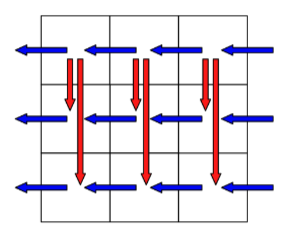

In [10]:
def communicate(self: Computation, buffer_name: str, var: IterVar, rotate_factors: List[IterVar] = []):
  access = next(filter(lambda acc: acc.buffer.name == buffer_name, self.accesses))
  assert access.buffer.sharding
  assert IterKind.Serial == self.iter_kinds.get(var, IterKind.Serial)
  new_transfers = self.transfers.copy()
  transed = new_transfers.get(var, ())
  assert access not in transed

  i = self.iter_vars.index(var)

  access_schedule = None
  if len(rotate_factors) > 0:
    name = self.name()
    extent = self.schedule.range().dim_max_val(i).num_si() + 1
    nvar = str(var) + '_r'
    niter_vars = tuple([*self.iter_vars[:i], nvar, *self.iter_vars[i + 1:]])
    constraints = [f"{nvar} = ({' + '.join(map(str, rotate_factors))} + {var}) mod {extent}"]
    for factor in rotate_factors + [var]:
      i = self.iter_vars.index(factor)
      min = self.schedule.range().dim_min_val(i).num_si()
      max = self.schedule.range().dim_max_val(i).num_si()
      constraints.append(f"{min} <= {str(factor)} <= {max}")
    access_schedule = isl.map(
        f"{{ {name}[{','.join(map(str, self.iter_vars))}] -> {name}[{','.join(map(str, niter_vars))}] : {' and '.join(constraints)} }}")
  else:
    access_schedule = self.schedule.range().identity()

  # check validity
  schedule_to_sharding = self.schedule.apply_range(access_schedule).apply_domain(
      access.relation).apply_domain(access.buffer.sharding).reverse()  # schedule -> buffer
  dist_to_shard = schedule_to_sharding.project_out(isl.dim_type.IN, i + 1, len(self.iter_vars) - i - 1). \
      project_out(isl.dim_type.OUT, len(self.mesh.dims),
                  access.buffer.sharding.dim(isl.dim_type.OUT) - len(self.mesh.dims))
  assert dist_to_shard.is_single_valued(), "transfer can't read/write data cross multi nodes."

  new_transfers[var] = (Transfer(access, access_schedule), *transed)
  return replace(self, transfers=new_transfers)


Computation.communicate = communicate

s0_communicated = s0_sharded.communicate('A', ko, [no]). \
    communicate('B', ko)

s0_communicated

Computation(op='arith.mulf', domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[mo, no, ko, mi = m - 64mo, ni = n - 128no, ki = k - 256ko] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -63 + m <= 64mo <= m and -127 + n <= 128no <= n and -255 + k <= 256ko <= k }"), accesses=(Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=isl.map("{ C[m, n] -> C[x, y, m - 64x, local_n = n - 128y] : 0 <= m <= 511 and 0 <= n <= 1023 and 0 <= x <= 7 and -63 + m <= 64x <= m and 0 <= y <= 7 and -127 + n <= 128y <= n }"), usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), sharding=isl

Up to now, all the necessary components for computation have been defined, and we can start generating code. However, because transfer scheduling introduces new temporary buffers and data communication operations, supporting them in polyhedral representation is somewhat complex. This involves content related to polyhedral code generation. Early polyhedral compilation used the `2d+1` representation to mark the execution order of statements, but as programs became more complex, many maps became difficult to handle and analyze. Later, isl introduced the `schedule tree` approach, which uses a tree structure to represent the execution order of statements, making traversal and modification easier. Currently, isl supports generating ASTs from both `2d+1` representations and `schedule tree` representations. [tiramisu](http://tiramisu-compiler.org) uses the `2d+1` approach, while [akg-tvm](https://gitee.com/mindspore/akg/blob/master/src/poly/schedule_pass.cc) uses the `schedule tree` approach. Although different approaches are used, both generate isl ASTs, which are then traversed to generate platform-specific code.

The IR here is not complicated, so I use `2d+1` to represent and generate the AST. The following will define some extended AST node types:

In [11]:
class OpKind(IntEnum):
  # call(Assign, dest, src)
  Assign = 0
  # call(Access, buffer, *(int | slice))
  Access = 1
  # call(Trans, commPattern, sendbuf, dest, recvbuf, source)
  Trans = 2
  # call(Alloc, name, *dims)
  Alloc = 3
  # call(Rank, *ids)
  Rank = 4
  # call(CommSendrecv)
  CommSendrecv = 5
  # call(CommBroadcast, *commGroups)
  CommBroadcast = 6
  # call(CommShift, *commGroups, direction)
  CommShift = 7
  # call(AssertEqual, a, b)
  AssertEqual = 8
  # call(AugAssign, dest, src)
  AugAssign = 9

  # call(Slice, begin, end)
  Slice = 128
  Add = 129
  Mul = 130
  MatMul = 131
  MatMulTransA = 132


def call_from(build: isl.ast_build, op: OpKind, *args: List[isl.ast_expr | str]):
  assert isinstance(op, OpKind)
  l = isl.ast_expr_list(len(args))
  for i in range(len(args)):
    match args[i]:
      case isl.ast_expr():
        l = l.add(args[i])
      case int() | isl.val():
        l = l.add(isl.ast_expr.from_val(args[i]))
      case str():
        l = l.add(isl.ast_expr.from_id(args[i]))
      case isl.pw_aff():
        l = l.add(build.expr_from(isl.pw_aff(str(args[i]))))
      case _:
        raise ValueError(f"Unsupported argument type: {type(args[i])}")
  return isl.ast_expr.call(isl.ast_expr.from_id(op.name), l)


Add the analysis set of `TransferScheduleInfo, ComputationScheduleInfo` to collect information related to the conversion of the original schedule to the `2d+1` representation. Here, I have additionally added `access_schedule` to `TransferScheduleInfo` to support different access patterns, such as rotate. `access_adapt_schedule` is used to align dependencies of the same dimension. For example, when the k-dimension of matrix A is indexed by means of rotate, and the k-dimension of matrix B needs to match it for correct computation, the corresponding `access_adapt_schedule` needs to be added to matrix B.

In [12]:
def get_kelly_map(self: Computation, *tps: Tuple[int, int]):
  ndim = self.schedule.dim(isl.dim_type.OUT)
  sche = self.schedule.range().identity()
  d = {p[0] + 1: p[1] for p in tps}
  for i in range(ndim):
    sche = sche.insert_dims(isl.dim_type.OUT, i * 2,
                            1).fix_val(isl.dim_type.OUT, i * 2, d.get(i, 0))
  return sche.set_tuple_name(isl.dim_type.OUT, sche.get_tuple_name(isl.dim_type.IN))


@dataclass(frozen=True, unsafe_hash=True)
class TransferScheduleInfo:
  dim: int
  access_map: isl.map
  access_shard_map: isl.map  # schedule -> buffer
  access_schedule: isl.map  # schedule -> new schedule
  access_adapt_schedule: isl.map | None
  box_hull: isl.fixed_box
  alloc_schedule: isl.map
  trans_schedule: isl.map
  redundancies: Tuple[int, ...]

  @property
  def alloc_name(self):
    return self.alloc_schedule.tuple_name(isl.dim_type.IN)

  @property
  def trans_name(self):
    return self.trans_schedule.tuple_name(isl.dim_type.IN)


@dataclass(frozen=True, unsafe_hash=True)
class ComputationScheduleInfo:
  comp_schedule: isl.map
  assign_kind: OpKind
  op_kind: OpKind

  @property
  def comp_name(self):
    return self.comp_schedule.tuple_name(isl.dim_type.IN)


def get_transfer_schedule_info(self: Computation, transfer: Transfer, dim: int, order: int):
  sched_domain = self.schedule.range()
  ndim = sched_domain.n_dim()
  access_map = self.schedule.apply_domain(transfer.access.relation).reverse()
  access_shard_map = access_map.apply_range(transfer.access.buffer.sharding)
  box_hull = access_map. \
      eliminate(isl.dim_type.IN, dim + 1, ndim - dim - 1). \
      range_simple_fixed_box_hull()

  trans_name = OpKind.Trans.name + transfer.access.buffer.name
  alloc_name = OpKind.Alloc.name + trans_name
  alloc_schedule = get_kelly_map(self, (dim, order)). \
      intersect_domain(sched_domain). \
      project_out(isl.dim_type.IN, dim + 1, ndim - (dim + 1)). \
      set_domain_tuple(alloc_name)
  for drop_dim in range(dim + 1, ndim):
    alloc_schedule = alloc_schedule.fix_si(isl.dim_type.OUT, drop_dim * 2 + 1, 0)
  order += 1

  trans_schedule = get_kelly_map(self, (dim, order)). \
      intersect_domain(sched_domain). \
      set_domain_tuple(trans_name)

  # find dropped dimensions
  redundancies = []
  cons_free_map = access_map.drop_constraints_not_involving_dims(
      isl.dim_type.OUT, 0, len(transfer.access.buffer.dims))
  for i in range(dim, ndim):
    if not cons_free_map.involves_dims(isl.dim_type.IN, i, 1):
      trans_schedule = trans_schedule.fix_si(isl.dim_type.IN, i, 0)
      redundancies.append(i)

  order += 1

  return TransferScheduleInfo(dim, access_map, access_shard_map, transfer.schedule, 
                              None, box_hull, alloc_schedule, trans_schedule,
                              tuple(redundancies))


s0_trans_info_0 = get_transfer_schedule_info(
    s0_communicated, s0_communicated.transfers[ko][0], 2, 0)
s0_trans_info_1 = get_transfer_schedule_info(
    s0_communicated, s0_communicated.transfers[ko][1], 2, 0)
print(s0_trans_info_0)
print(s0_trans_info_1)

TransferScheduleInfo(dim=2, access_map=isl.map("{ s0[mo, no, ko, mi, ni, ki] -> B[256ko + ki, 128no + ni] : mi >= 0 and -64mo <= mi <= 511 - 64mo and mi <= 63 and ni >= 0 and -128no <= ni <= 1023 - 128no and ni <= 127 and ki >= 0 and -256ko <= ki <= 2047 - 256ko and ki <= 255 }"), access_shard_map=isl.map("{ s0[mo, no, ko, mi, ni, ki] -> B[x, y, 256ko + ki - 256x, local_n = 128no + ni - 128y] : mi >= 0 and -64mo <= mi <= 511 - 64mo and mi <= 63 and ni >= 0 and -128no <= ni <= 1023 - 128no and ni <= 127 and ki >= 0 and -256ko <= ki <= 2047 - 256ko and ki <= 255 and 0 <= x <= 7 and -255 + 256ko + ki <= 256x <= 256ko + ki and 0 <= y <= 7 and -127 + 128no + ni <= 128y <= 128no + ni }"), access_schedule=isl.map("{ s0[mo, no, ko, mi, ni, ki] -> s0[mo' = mo, no' = no, ko' = ko, mi' = mi, ni' = ni, ki' = ki] : mi >= 0 and -64mo <= mi <= 511 - 64mo and mi <= 63 and ni >= 0 and -128no <= ni <= 1023 - 128no and ni <= 127 and ki >= 0 and -256ko <= ki <= 2047 - 256ko and ki <= 255 }"), access_adapt

With the scheduling information, we already know the communication node/offset information. However, since the distributed backend I chose here is MPI, it is impossible to directly read and write data based on the above information, and we can only rely on the communication primitives it provides. For example, when multiple ranks need to fetch data from the same rank, the broadcast primitive must be used for normal communication; if the sendrecv primitive is used, it needs to be called multiple times with specified ranks. Therefore, it is also necessary to detect the communication mode based on the communication schedule. My approach here is to change the time dimension in which communication occurs to obtain the expression of the change in the source rank over time. If the source rank remains unchanged, it may be p2p or broadcast, and then further check whether the source rank and destination rank are bijective to determine if it is broadcast. When the source rank changes over time, we can determine whether it is a ring and the direction of the ring:

In [13]:
@dataclass(frozen=True, unsafe_hash=True)
class CommPattern:
  def build_call(self, build):
    pass


@dataclass(frozen=True, unsafe_hash=True)
class SendRecv(CommPattern):
  def build_call(self, build):
    return call_from(build, OpKind.CommSendrecv)


@dataclass(frozen=True, unsafe_hash=True)
class Broadcast(CommPattern):
  axes: tuple[int, ...]

  def build_call(self, build):
    return call_from(build, OpKind.CommBroadcast, *self.axes)


@dataclass(frozen=True, unsafe_hash=True)
class Shift(CommPattern):
  axes: tuple[int, ...]
  direction: int

  def build_call(self, build):
    return call_from(build, OpKind.CommShift, *self.axes, self.direction)


def drop_dims(sche: isl.map | isl.aff, redundancies: Tuple[int] = ()):
  dims = list(redundancies)
  dims.sort()
  j = 0
  for i in range(len(dims)):
    if isinstance(sche, isl.map):
      sche = sche.project_out(isl.dim_type.IN, dims[i] - j, 1)
    elif isinstance(sche, isl.pw_aff):
      sche = sche.drop_dims(isl.dim_type.IN, dims[i] - j, 1)
    else:
      raise NotImplementedError
    j += 1
  return sche


def detect_communication_pattern(self: Computation, info: TransferScheduleInfo):
  domain_ndim = info.access_map.dim(isl.dim_type.IN)
  shard_ndim = info.access_shard_map.dim(isl.dim_type.OUT)
  mesh_ndim = len(self.mesh.dims)
  comm_dim = info.dim
  access_shard_map = info.access_shard_map.apply_domain(info.access_schedule)
  access_src_rank = access_shard_map. \
      project_out(isl.dim_type.OUT, mesh_ndim, shard_ndim - mesh_ndim).\
      project_out(isl.dim_type.IN, info.dim + 1, domain_ndim - info.dim - 1)
  # mesh_ndim = len(self.mesh.dims)
  # access_shard_map = info.access_shard_map.apply_domain(info.access_schedule)
  # cons_free_map = access_shard_map.drop_constraints_not_involving_dims(
  #     isl.dim_type.OUT, 0, access_shard_map.dim(isl.dim_type.OUT))
  # redundancies = []
  # for i in range(comm_dim, cons_free_map.dim(isl.dim_type.IN)):
  #   if not cons_free_map.involves_dims(isl.dim_type.IN, i, 1):
  #     redundancies.append(i)

  # access_src_rank = drop_dims(access_shard_map, redundancies)
  access_src_pma = access_src_rank.as_pw_multi_aff()
  delta_vals = ','.join(
    ['1' if i == comm_dim else '0' for i in range(access_src_pma.dim(isl.dim_type.IN))])
  access_next_src_pma = isl.pw_multi_aff.identity_on_domain(
      access_src_pma.domain_space()).add_constant(isl.multi_val(f'{{[{delta_vals}]}}'))
  src_rank_deltas = access_src_pma.pullback(access_next_src_pma).sub(access_src_pma).coalesce()
  comm_patterns = []
  for i in range(mesh_ndim):
    pa = src_rank_deltas.at(i)
    if pa.is_cst():
      match pa.max_val().num_si():
        case 0:  # not involved
          comm_patterns.append(SendRecv())
        case 1:  # changed with time.
          if not access_src_rank.is_bijective():  # detect broadcast
            unbounded = access_src_rank.drop_constraints_not_involving_dims(
                isl.dim_type.OUT, 0, mesh_ndim)
            if not unbounded.involves_dims(isl.dim_type.IN, i, 1):
              comm_patterns.append(Broadcast((i,)))
            else:
              comm_patterns.append(SendRecv())
          else:
            comm_patterns.append(SendRecv())
    else:
      points = []
      pa.as_map().range().foreach_point(lambda x: points.append(isl.set(x)))
      points = reduce(lambda acc, x: acc.union(x), points, isl.set.empty(
          isl.space.unit().add_dims(isl.dim_type.SET, 1)))
      extent = self.schedule.range().dim_max_val(info.dim).num_si()
      cw_set = isl.set(f'{{[1]; [-{extent}]}}')
      ccw_set = isl.set(f'{{[-1]; [{extent}]}}')
      if points.is_equal(cw_set):
        comm_patterns.append(Shift((i,), 1))
      elif points.is_equal(ccw_set):
        comm_patterns.append(Shift((i,), -1))

  special = sum([isinstance(p, (Broadcast, Shift)) for p in comm_patterns])
  assert special <= 1
  return SendRecv() if special == 0 else next(filter(lambda p: not isinstance(p, SendRecv), comm_patterns))


print(detect_communication_pattern(s0_communicated, s0_trans_info_0))
print(detect_communication_pattern(s0_communicated, s0_trans_info_1))

Broadcast(axes=(0,))
Shift(axes=(1,), direction=1)


The previous step detected the data transmission pattern through `TransferScheduleInfo`. We still need to obtain `ComputationScheduleInfo`. This step is relatively simple; we just need to convert the original schedule into a `2d+1` representation:

In [14]:
@dataclass(frozen=True, unsafe_hash=True)
class ScheduleInfo:
  trans_infos: Tuple[TransferScheduleInfo]
  comp_infos: Tuple[ComputationScheduleInfo]


def get_schedule_info(self: Computation):
  transfer_sche_infos: List[TransferScheduleInfo] = []
  used_orders = []
  for (var, accesses) in self.transfers.items():
    dim = self.iter_vars.index(var)
    order = 0
    for access in accesses:
      transfer_sche_infos.append(get_transfer_schedule_info(self, access, dim, order))
      order += 2
      used_orders.append((dim, order))
  # check dim bindings
  for dim, dim_indices in self.dim_bindings.items():
    worklist: List[Tuple[int, TransferScheduleInfo, AccessDimIndex]] = []
    for dim_index in dim_indices:
      for var, trans_infos in self.transfers.items():
        for i, trans in enumerate(trans_infos):
          if self.accesses[dim_index.access_idx] == trans.access:
            worklist.append((i, transfer_sche_infos[i], dim_index))
    # process worklist
    if len(worklist) > 1:
      access_dim_maps: List[isl.map] = []
      for workitem in worklist:
        _, trans_info, dim_index = workitem
        access_dim_map: isl.map = trans_info.access_map.apply_domain(trans_info.access_schedule)
        access_dim_map = access_dim_map.project_out(isl.dim_type.OUT, 0, dim_index.buffer_dim)
        access_dim_map = access_dim_map.project_out(
            isl.dim_type.OUT, 1, access_dim_map.dim(isl.dim_type.OUT) - 1)
        access_dim_maps.append(access_dim_map)
      for i in range(len(access_dim_maps) - 1):
        # when dim not equal, add index schedule
        if not access_dim_maps[i].is_equal(access_dim_maps[i + 1]):
          a = worklist[i][1]
          b = worklist[i + 1][1]
          if a.access_schedule.is_identity():
            assert a.access_adapt_schedule is None
            transfer_sche_infos[worklist[i][0]] = replace(a, access_adapt_schedule=b.access_schedule)
          elif b.access_schedule.is_identity():
            assert b.access_adapt_schedule is None
            transfer_sche_infos[worklist[i + 1][0]] = replace(b, access_adapt_schedule=a.access_schedule)
          else:
            raise ValueError("Incompatible access schedules")

  in_iters = set(itertools.flatten(
      [acc.buffer.dims for acc in self.accesses if acc.buffer.usage is UsageKind.Input]))
  out_iters = set(itertools.flatten(
      [acc.buffer.dims for acc in self.accesses if acc.buffer.usage is UsageKind.Output]))

  op_kind = None
  match self.op:
    case OpKind():
      op_kind = self.op
    case 'arith.mulf':
      op_kind = OpKind.Mul
    case _:
      raise NotImplementedError()

  comp_schedule = ComputationScheduleInfo(get_kelly_map(
      self, *used_orders).intersect_domain(self.schedule.range()),
      OpKind.AugAssign if len(in_iters) > len(out_iters) else OpKind.Assign,
      op_kind)
  return ScheduleInfo(tuple(transfer_sche_infos), (comp_schedule,))


s0_schedule_info = get_schedule_info(s0_communicated)
s0_schedule_info

ScheduleInfo(trans_infos=(TransferScheduleInfo(dim=2, access_map=isl.map("{ s0[mo, no, ko, mi, ni, ki] -> B[256ko + ki, 128no + ni] : mi >= 0 and -64mo <= mi <= 511 - 64mo and mi <= 63 and ni >= 0 and -128no <= ni <= 1023 - 128no and ni <= 127 and ki >= 0 and -256ko <= ki <= 2047 - 256ko and ki <= 255 }"), access_shard_map=isl.map("{ s0[mo, no, ko, mi, ni, ki] -> B[x, y, 256ko + ki - 256x, local_n = 128no + ni - 128y] : mi >= 0 and -64mo <= mi <= 511 - 64mo and mi <= 63 and ni >= 0 and -128no <= ni <= 1023 - 128no and ni <= 127 and ki >= 0 and -256ko <= ki <= 2047 - 256ko and ki <= 255 and 0 <= x <= 7 and -255 + 256ko + ki <= 256x <= 256ko + ki and 0 <= y <= 7 and -127 + 128no + ni <= 128y <= 128no + ni }"), access_schedule=isl.map("{ s0[mo, no, ko, mi, ni, ki] -> s0[mo' = mo, no' = no, ko' = ko, mi' = mi, ni' = ni, ki' = ki] : mi >= 0 and -64mo <= mi <= 511 - 64mo and mi <= 63 and ni >= 0 and -128no <= ni <= 1023 - 128no and ni <= 127 and ki >= 0 and -256ko <= ki <= 2047 - 256ko and k

Generate the AST based on `ScheduleInfo`, and at the same time, use the above analysis to insert the required operations into the AST:

In [15]:
def lower_computation(self: Computation):
  schedule_info = get_schedule_info(self)
  # process tensorized
  sched_domain = self.schedule.range()
  sched_domain_min = self.schedule.range()
  sched_domain_max = self.schedule.range()
  tensorized_dims = []
  for i, v in enumerate(self.iter_vars):
    if self.iter_kinds.get(v) is IterKind.Tensorize:
      sched_domain_min = sched_domain_min.fix_val(isl.dim_type.SET, i, sched_domain.dim_min_val(i))
      sched_domain_max = sched_domain_max.fix_val(isl.dim_type.SET, i, sched_domain.dim_max_val(i))
      tensorized_dims.append(i)

  def fix_dims(sche: isl.map):
    for d in tensorized_dims:
      sche = sche.fix_si(isl.dim_type.OUT, (2 * d) + 1, 0)
    return sche

  def drop_dims1(sche: isl.map | isl.aff, redundancies: Tuple[int] = ()):
    dims = list(set([*redundancies, *tensorized_dims]))
    dims.sort()
    j = 0
    for i in range(len(dims)):
      if isinstance(sche, isl.map):
        sche = sche.project_out(isl.dim_type.IN, dims[i] - j, 1)
      elif isinstance(sche, isl.pw_aff):
        sche = sche.drop_dims(isl.dim_type.IN, dims[i] - j, 1)
      else:
        raise NotImplementedError
      j += 1
    return sche

  def get_box(map: isl.map) -> isl.multi_val:
    min = drop_dims1(map.intersect_domain(sched_domain_min))
    max = drop_dims1(map.intersect_domain(sched_domain_max))
    diff = max.as_pw_multi_aff().sub(min.as_pw_multi_aff())
    assert diff.is_cst()
    return diff.max_multi_val()

  full_sche_map = isl.union_map.empty()
  for info in schedule_info.comp_infos:
    full_sche_map = full_sche_map.union(fix_dims(info.comp_schedule))
  for info in schedule_info.trans_infos:
    full_sche_map = full_sche_map.union(fix_dims(info.alloc_schedule))
    full_sche_map = full_sche_map.union(fix_dims(info.trans_schedule))
  alloc_info_map = {info.alloc_name: info for info in schedule_info.trans_infos}
  trans_info_map = {info.trans_name: info for info in schedule_info.trans_infos}
  comp_info_map = {info.comp_name: info for info in schedule_info.comp_infos}

  def at_each_domain(node: isl.ast_node_user, build: isl.ast_build) -> isl.ast_node:
    origin_expr = node.expr()
    if not isinstance(origin_expr, isl.ast_expr_op_call):
      return node

    call_id: isl.ast_expr_id = origin_expr.op_arg(0)
    call_id_name = call_id.id().name()
    # alloc
    if call_id_name in alloc_info_map:
      info = alloc_info_map[call_id_name]
      box_shape = info.box_hull.get_size()
      rank = box_shape.size()
      alloc = call_from(build, OpKind.Alloc, info.trans_name,
                        *[box_shape.at(i) for i in range(rank)])
      return isl.ast_node_user(alloc)

    # trans
    if call_id_name in trans_info_map:
      info = trans_info_map[call_id_name]
      pattern = detect_communication_pattern(self, info)
      select_ranks = list(range(len(self.mesh.dims)))
      match pattern:
        case Broadcast():
          select_ranks = list(filter(lambda i: i in pattern.axes, select_ranks))

      def drop_dims2(x): return drop_dims1(x, info.redundancies)

      src_shard_pma = info.access_shard_map.as_pw_multi_aff()
      access_sche_pma = info.access_schedule.as_pw_multi_aff()
      src_shard_pma = src_shard_pma.pullback(access_sche_pma)
      if info.access_adapt_schedule:
        src_shard_pma = src_shard_pma.pullback(info.access_adapt_schedule.as_pw_multi_aff())
      src_rank = call_from(build, OpKind.Rank, *[drop_dims2(src_shard_pma.at(i))
                           for i in select_ranks])

      dest_rank_pma = info.access_map.domain().identity().as_pw_multi_aff()
      dest_rank_pma = dest_rank_pma.pullback(access_sche_pma)
      dest_rank = call_from(build, OpKind.Rank, *
                            [drop_dims2(dest_rank_pma.at(i)) for i in select_ranks])

      src_tensor_box = get_box(info.access_shard_map)
      src_slice = call_from(build, OpKind.Access, info.access_shard_map.tuple_name(isl.dim_type.OUT),
                            *[call_from(build, OpKind.Slice, drop_dims2(src_shard_pma.at(i)),
                                        drop_dims2(src_shard_pma.at(i)).add_constant(src_tensor_box.at(i)).add_constant(1))
                              for i in range(len(self.mesh.dims), src_shard_pma.dim(isl.dim_type.OUT))])

      dest_start_pma = info.box_hull.get_offset().as_pw_multi_aff()
      dest_origin_pma = info.access_map.as_pw_multi_aff()
      dest_tensor_box = get_box(info.access_map)
      dest_pma = dest_origin_pma.sub(dest_start_pma)
      dest_pma = dest_pma.pullback(access_sche_pma)
      dest_slice = call_from(build, OpKind.Access, info.trans_name,
                             *[call_from(build, OpKind.Slice, drop_dims2(dest_pma.at(i)),
                                         drop_dims2(dest_pma.at(i)).add_constant(dest_tensor_box.at(i)).add_constant(1))
                               for i in range(dest_pma.size())])

      trans = call_from(build, OpKind.Trans, pattern.build_call(build),
                        src_slice, src_rank, dest_slice, dest_rank)
      return isl.ast_node_user(trans)
    if call_id_name in comp_info_map:
      info = comp_info_map[call_id_name]
      access_exprs = []
      for access in self.accesses:
        trans_name = OpKind.Trans.name + access.buffer.name
        if trans_name in trans_info_map:
          trans_info = trans_info_map[trans_name]
          access_sche_pma = trans_info.access_schedule.as_pw_multi_aff()
          dest_start_pma = trans_info.box_hull.get_offset().as_pw_multi_aff()
          dest_origin_pma = trans_info.access_map.as_pw_multi_aff()
          dest_tensor_box = get_box(trans_info.access_map)
          dest_pma = dest_origin_pma.sub(dest_start_pma)
          dest_pma = dest_pma.pullback(access_sche_pma)
          access_exprs.append(call_from(build, OpKind.Access, trans_name, *
                              [call_from(build, OpKind.Slice, drop_dims1(dest_pma.at(i)), drop_dims1(dest_pma.at(i)).add_constant(dest_tensor_box.at(i)).add_constant(1))
                               for i in range(dest_pma.size())]))
        else:
          access_shard_map = self.schedule.reverse().apply_range(
              access.relation).apply_range(access.buffer.sharding)
          dest_shard_pma = access_shard_map.as_pw_multi_aff()
          dest_tensor_box = get_box(access_shard_map)
          dest_slice = call_from(build, OpKind.Access, access.buffer.name, *[
              call_from(build, OpKind.Slice, drop_dims1(dest_shard_pma.at(i)),
                        drop_dims1(dest_shard_pma.at(i)).add_constant(dest_tensor_box.at(i)).add_constant(1))
              for i in range(len(self.mesh.dims), dest_shard_pma.dim(isl.dim_type.OUT))])
          access_exprs.append(dest_slice)
      call_expr = call_from(build, info.assign_kind,
                            access_exprs[0],
                            call_from(build, info.op_kind, access_exprs[1], access_exprs[2]))
      return isl.ast_node_user(call_expr)
    return node

  builtin_iters = list(map(str, self.mesh.dims))

  def at_each_for(node: isl.ast_node_for, build: isl.ast_build) -> isl.ast_node:
    it = node.get_iterator()
    if isinstance(it, isl.ast_expr_id) and it.id().name() in builtin_iters:
      node = node.set_annotation(IterKind.Distributed.name)
    return node

  ast_build = isl.ast_build()
  ast_build = ast_build.set_at_each_domain(at_each_domain)
  ast_build = ast_build.set_after_each_for(at_each_for)
  iter_ids = []
  ndim = len(self.iter_vars)
  comp_schedule = schedule_info.comp_infos[0].comp_schedule
  iter_kinds = {k.name: v for (k, v) in self.iter_kinds.items()}
  for i in range(ndim):
    iter_ids.append(f'c{i}')
    name = comp_schedule.dim_name(isl.dim_type.OUT, 2 * i + 1)
    if iter_kinds.get(name) is IterKind.Distributed:
      name = str(self.mesh.dims[i])
    iter_ids.append(name)
  ast_build = ast_build.set_iterators('(' + ','.join(iter_ids) + ')')
  ast_node = ast_build.node_from_schedule_map(full_sche_map)
  return ast_node


with open('tmp/pumma.py', 'w') as f:
  ast_computation = lower_computation(s0_communicated)
  printer = isl.printer.to_file(f)
  print_options = isl.ast_print_options.alloc()
  printer.set_output_format(isl.format.C)
  printer = ast_computation.print(printer, print_options)
  printer.flush()

with open('tmp/pumma.py', 'r') as f:
  print(f.read())

for (int x = 0; x <= 7; x += 1)
  for (int y = 0; y <= 7; y += 1)
    for (int ko = 0; ko <= 7; ko += 1) {
      Alloc(TransB, 256, 128);
      for (int ni = 0; ni <= 127; ni += 1)
        for (int ki = 0; ki <= 255; ki += 1)
          Trans(CommBroadcast(0), Access(B, Slice(ki, ki + 1), Slice(ni, ni + 1)), Rank((y + ko) % 8), Access(TransB, Slice(ki, ki + 1), Slice(ni, ni + 1)), Rank(x));
      Alloc(TransA, 64, 256);
      for (int mi = 0; mi <= 63; mi += 1)
        for (int ki = 0; ki <= 255; ki += 1)
          Trans(CommShift(1, 1), Access(A, Slice(mi, mi + 1), Slice(ki, ki + 1)), Rank(x, (y + ko) % 8), Access(TransA, Slice(mi, mi + 1), Slice(ki, ki + 1)), Rank(x, y));
      for (int mi = 0; mi <= 63; mi += 1)
        for (int ni = 0; ni <= 127; ni += 1)
          for (int ki = 0; ki <= 255; ki += 1)
            AugAssign(Access(C, Slice(mi, mi + 1), Slice(ni, ni + 1)), Mul(Access(TransA, Slice(mi, mi + 1), Slice(ki, ki + 1)), Access(TransB, Slice(ki, ki + 1), Slice(ni, ni + 1))));

Up to this step, we have obtained a relatively complete pseudocode. However, we can see that it is entirely loop-based, with relatively low performance. Here, we will add a `tensorize` schedule to fold the dimensions, change program to tile-based:

In [16]:
def tensorize(self: Computation, vars: List[IterVar], new_op: OpKind = None):
  new_kinds = self.iter_kinds.copy()
  for var in vars:
    assert new_kinds.get(var, None) in (None, IterKind.Serial)
    new_kinds[var] = IterKind.Tensorize
  if new_op:
    self = replace(self, op=new_op)
  return replace(self, iter_kinds=new_kinds)


Computation.tensorize = tensorize

s0_tensorized = s0_communicated.tensorize([mi, ni, ki], OpKind.MatMul)
s0_tensorized

Computation(op=<OpKind.MatMul: 131>, domain=isl.set("{ s0[k, m, n] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 }"), schedule=isl.map("{ s0[k, m, n] -> s0[mo, no, ko, mi = m - 64mo, ni = n - 128no, ki = k - 256ko] : 0 <= k <= 2047 and 0 <= m <= 511 and 0 <= n <= 1023 and -63 + m <= 64mo <= m and -127 + n <= 128no <= n and -255 + k <= 256ko <= k }"), accesses=(Access(buffer=Buffer(name='C', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='n', lower_bound=0, upper_bound=1024, step=1)), dtype=Float32Type(), sharding=isl.map("{ C[m, n] -> C[x, y, m - 64x, local_n = n - 128y] : 0 <= m <= 511 and 0 <= n <= 1023 and 0 <= x <= 7 and -63 + m <= 64x <= m and 0 <= y <= 7 and -127 + n <= 128y <= n }"), usage=<UsageKind.Output: 1>), relation=isl.map("{ s0[k, m, n] -> C[m, n] }")), Access(buffer=Buffer(name='A', dims=(IterVar(name='m', lower_bound=0, upper_bound=512, step=1), IterVar(name='k', lower_bound=0, upper_bound=2048, step=1)), dtype=Float32Type(), shar

In [17]:
with open('tmp/pumma.py', 'w') as f:
  ast_computation = lower_computation(s0_tensorized)
  printer = isl.printer.to_file(f)
  print_options = isl.ast_print_options.alloc()
  printer.set_output_format(isl.format.C)
  printer = ast_computation.print(printer, print_options)
  printer.flush()

with open('tmp/pumma.py', 'r') as f:
  print(f.read())

for (int x = 0; x <= 7; x += 1)
  for (int y = 0; y <= 7; y += 1)
    for (int ko = 0; ko <= 7; ko += 1) {
      Alloc(TransB, 256, 128);
      Trans(CommBroadcast(0), Access(B, Slice(0, 256), Slice(0, 128)), Rank((y + ko) % 8), Access(TransB, Slice(0, 256), Slice(0, 128)), Rank(x));
      Alloc(TransA, 64, 256);
      Trans(CommShift(1, 1), Access(A, Slice(0, 64), Slice(0, 256)), Rank(x, (y + ko) % 8), Access(TransA, Slice(0, 64), Slice(0, 256)), Rank(x, y));
      AugAssign(Access(C, Slice(0, 64), Slice(0, 128)), MatMul(Access(TransA, Slice(0, 64), Slice(0, 256)), Access(TransB, Slice(0, 256), Slice(0, 128))));
    }



Now we have obtained the AST for the calculation part. To enable it to execute properly, we still need to prepare the input and output. Here, I will directly generate code for `Access`:

In [18]:
def lower_shard(self: Computation, access: Access) -> Tuple[isl.ast_build, isl.ast_build]:
  sharding = access.buffer.sharding
  assert sharding
  builtin_iters = list(map(str, self.mesh.dims))

  access_global_map = sharding.reverse().set_tuple_id(
      isl.dim_type.OUT, 'Global' + access.buffer.name)

  redundancies = []
  cons_free_map = access_global_map.drop_constraints_not_involving_dims(
      isl.dim_type.OUT, 0, access_global_map.dim(isl.dim_type.OUT))
  for i in range(0, access_global_map.dim(isl.dim_type.IN)):
    if not cons_free_map.involves_dims(isl.dim_type.IN, i, 1):
      redundancies.append(i)

  access_global_pma = access_global_map.as_pw_multi_aff()
  access_global_domain = sharding.reverse().domain()
  buffer_local_shape = access_global_domain.project_out(
      isl.dim_type.SET, 0, len(self.mesh.dims)).simple_fixed_box_hull().size()
  access_local_map = sharding.reverse().domain().identity().project_out(
      isl.dim_type.OUT, 0, len(self.mesh.dims)).set_range_tuple(access.buffer.name)
  access_local_pma = access_local_map.as_pw_multi_aff()

  ast_build = isl.ast_build()

  def at_each_domain(node: isl.ast_node_user, build: isl.ast_build) -> isl.ast_node:
    
    access_global = call_from(build, OpKind.Access, access_global_pma.tuple_name(
        isl.dim_type.OUT), *[drop_dims(access_global_pma.at(i), redundancies) for i in range(access_global_pma.size())])
    access_local = call_from(build, OpKind.Access, access_local_pma.tuple_name(
        isl.dim_type.OUT), *[drop_dims(access_local_pma.at(i), redundancies) for i in range(access_local_pma.size())])

    call = call_from(build, OpKind.Assign if access.buffer.usage ==
                     UsageKind.Input else OpKind.AssertEqual, access_local, access_global)
    return isl.ast_node_user(call)

  def at_each_for(node: isl.ast_node_for, build: isl.ast_build) -> isl.ast_node:
    it = node.get_iterator()
    if isinstance(it, isl.ast_expr_id) and it.id().name() in builtin_iters:
      node = node.set_annotation(IterKind.Distributed.name)
    return node

  ast_build = ast_build.set_at_each_domain(at_each_domain)
  ast_build = ast_build.set_after_each_for(at_each_for)
  ast_build = ast_build.set_iterators(
      '(' + ', '.join(map(str, chain(self.mesh.dims, access.buffer.dims))) + ')')
  ast_node = ast_build.node_from_schedule_map(sharding.range().identity())
  alloc = isl.ast_node_user(call_from(ast_build, OpKind.Alloc, access.buffer.name, *
                                      [buffer_local_shape.at(i) for i in range(buffer_local_shape.size())]))
  return (alloc, ast_node)

with open('tmp/pumma.py', 'w') as f:
  ast_shard_buffer_0 = lower_shard(s0_communicated, s0_communicated.accesses[0])
  ast_shard_buffer_1 = lower_shard(s0_communicated, s0_communicated.accesses[1])
  ast_shard_buffer_2 = lower_shard(s0_communicated, s0_communicated.accesses[2])
  printer = isl.printer.to_file(f)
  print_options = isl.ast_print_options.alloc()
  printer.set_output_format(isl.format.C)
  printer = ast_shard_buffer_0[0].print(printer, print_options)
  printer = ast_shard_buffer_0[1].print(printer, print_options)
  printer = ast_shard_buffer_1[0].print(printer, print_options)
  printer = ast_shard_buffer_1[1].print(printer, print_options)
  printer = ast_shard_buffer_2[0].print(printer, print_options)
  printer = ast_shard_buffer_2[1].print(printer, print_options)
  printer.flush()
  
with open('tmp/pumma.py', 'r') as f:
  print(f.read())

Alloc(C, 64, 128);
for (int x = 0; x <= 7; x += 1)
  for (int y = 0; y <= 7; y += 1)
    for (int m = 0; m <= 63; m += 1)
      for (int n = 0; n <= 127; n += 1)
        AssertEqual(Access(C, m, n), Access(GlobalC, 64 * x + m, 128 * y + n));
Alloc(A, 64, 256);
for (int x = 0; x <= 7; x += 1)
  for (int y = 0; y <= 7; y += 1)
    for (int m = 0; m <= 63; m += 1)
      for (int k = 0; k <= 255; k += 1)
        Assign(Access(A, m, k), Access(GlobalA, 64 * x + m, 256 * y + k));
Alloc(B, 256, 128);
for (int x = 0; x <= 7; x += 1)
  for (int y = 0; y <= 7; y += 1)
    for (int k = 0; k <= 255; k += 1)
      for (int n = 0; n <= 127; n += 1)
        Assign(Access(B, k, n), Access(GlobalB, 256 * x + k, 128 * y + n));



After having all the ASTs, it is necessary to generate the corresponding backend code. ISL provides a printer for users, and I have added a Python-style printer implementation:

In [19]:

def print_python_style_item(printer: isl.printer, item: isl.ast_expr | str):
  match item:
    case str():
      printer.print_str(item)
    case isl.ast_expr():
      expr = item
      match expr:
        case isl.ast_expr_op_call():
          op_name = expr.get_op_arg(0).id().name()
          match op_name:
            case OpKind.Access.name:
              print_python_style_item(printer, expr.get_op_arg(1))  # buffer name
              printer.print_str("[")
              for i in range(2, expr.op_n_arg()):
                print_python_style_item(printer, expr.get_op_arg(i))
                printer.print_str(", "[i - expr.op_n_arg():-1])
              printer.print_str("]")
            case OpKind.Rank.name:
              printer.print_str("[")
              for i in range(1, expr.op_n_arg()):
                print_python_style_item(printer, expr.get_op_arg(i))
                printer.print_str(", "[i - expr.op_n_arg():-1])
              printer.print_str("]")
            case OpKind.Assign.name:
              print_python_style_items(printer, expr.get_op_arg(1), " = ", expr.get_op_arg(2))
            case OpKind.AugAssign.name:
              print_python_style_items(printer, expr.get_op_arg(1), " += ", expr.get_op_arg(2))
            case OpKind.Slice.name:
              print_python_style_items(printer, expr.get_op_arg(1), ":", expr.get_op_arg(2))
              if expr.op_n_arg() > 3:
                printer.print_str(":")
                print_python_style_item(printer, expr.get_op_arg(3))
            case OpKind.Alloc.name:
              print_python_style_item(printer, expr.get_op_arg(1))
              printer.print_str(" = np.zeros([")
              for i in range(2, expr.op_n_arg()):
                print_python_style_item(printer, expr.get_op_arg(i))
                printer.print_str(", "[i - expr.op_n_arg():-1])
              printer.print_str("])")
            case OpKind.AssertEqual.name:
              print_python_style_items(printer, "assert np.allclose(", expr.get_op_arg(1), ", ", expr.get_op_arg(2), ")")
            case OpKind.Trans.name:
              printer.print_str(op_name)
              printer.print_str('(')
              for i in range(1, expr.op_n_arg()):
                print_python_style_item(printer, expr.get_op_arg(i))
                printer.print_str(", "[i - expr.op_n_arg():-1])
              printer.print_str(')')
            case OpKind.Mul.name:
              print_python_style_items(printer, expr.get_op_arg(1), " * ", expr.get_op_arg(2))
            case OpKind.MatMul.name:
              print_python_style_items(printer, expr.get_op_arg(1), " @ ", expr.get_op_arg(2))
            case OpKind.MatMulTransA.name:
              print_python_style_items(printer, expr.get_op_arg(1), ".T", " @ ", expr.get_op_arg(2))
            case OpKind.CommShift.name:
              print_python_style_items(printer, expr.get_op_arg(0), "(")
              print_python_style_item(printer, '(')
              for i in range(1, expr.op_n_arg() - 1):
                print_python_style_items(printer, expr.get_op_arg(i), ',')
              print_python_style_item(printer, '),')
              print_python_style_item(printer, expr.get_op_arg(expr.op_n_arg() - 1))
              print_python_style_item(printer, ')')
            case _:
              printer.print_ast_expr(expr)
        case _:
          printer.print_ast_expr(expr)
    case _:
      raise NotImplementedError()


def print_python_style_items(printer: isl.printer, *items: List[isl.ast_expr | str]):
  for item in items:
    print_python_style_item(printer, item)


def print_python_style_user(printer: isl.printer, options: isl.ast_print_options, node: isl.ast_node):
  expr: isl.ast_expr = node.get_expr()
  printer.start_line()
  print_python_style_item(printer, expr)
  printer.end_line()
  return printer


def print_python_style_for(printer: isl.printer, options: isl.ast_print_options, node: isl.ast_node_for):
  (it, init, cond, inc) = node.get_iterator(), node.get_init(), node.get_cond(), node.get_inc()
  omit = False
  try:
    anno = node.annotation()
    if anno.name() == IterKind.Distributed.name:
      omit = True
  except:
    pass

  if not omit:
    printer.start_line()
    print_python_style_items(printer, "for ", it, " in range(", init,
                             ", ", cond.get_arg(1), " + 1", ", ", inc, "):\n")
    printer = printer.indent(4)
  printer = node.get_body().print(printer, options)
  if not omit:
    printer = printer.indent(-4)
  return printer


def print_python_style_block(printer: isl.printer, options: isl.ast_print_options, node: isl.ast_node_block):
  children = node.get_children()
  for i in range(children.size()):
    printer = children.get_at(i).print(printer, options)
  return printer

In [20]:
with open('tmp/pumma.py', 'w') as f:
  ast_computation = lower_computation(s0_tensorized)
  printer = isl.printer.to_file(f)
  print_options = isl.ast_print_options.alloc()
  print_options = print_options.set_print_for(print_python_style_for)
  print_options = print_options.set_print_user(print_python_style_user)
  print_options = print_options.set_print_block(print_python_style_block)
  printer.set_output_format(isl.format.C)
  printer = ast_computation.print(printer, print_options)
  printer.flush()

with open('tmp/pumma.py', 'r') as f:
  print(f.read())

for ko in range(0, 7 + 1, 1):
    TransB = np.zeros([256,128])
    Trans(CommBroadcast(0),B[0:256,0:128],[(y + ko) % 8],TransB[0:256,0:128],[x])
    TransA = np.zeros([64,256])
    Trans(CommShift((1,),1),A[0:64,0:256],[x,(y + ko) % 8],TransA[0:64,0:256],[x,y])
    C[0:64,0:128] += TransA[0:64,0:256] @ TransB[0:256,0:128]



During the process of generating the AST, I used a unified communication operation API. These APIs, along with some setup code, need to be implemented in the runtime. However, they are not included in the compilation process. For simplicity, I handled this by directly constructing strings and writing them into files:

In [21]:
def codegen_setup(self: Computation, printer: isl.printer) -> isl.printer:
  printer.print_str('import numpy as np\n')
  printer.print_str('from mpi4py import MPI\n')
  printer.print_str('from enum import IntEnum\n')
  printer.print_str('import sys\n')
  printer.print_str('RANK = MPI.COMM_WORLD.Get_rank()\n')
  printer.print_str(f'MESH = [{",".join(map(str, self.mesh.shape))}]\n')
  printer.print_str(f'COMM_ALL = MPI.COMM_WORLD.Create_cart(MESH)\n')
  printer.print_str(f"({','.join(map(str, self.mesh.dims))},) = PIDS = COMM_ALL.Get_coords(RANK)\n")

  printer.print_str(f"""

class CommBroadcast:
  def __init__(self, *axes: int):
    self.axes: tuple[int] = axes

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    comm = COMM_ALL.Sub([True if i in self.axes else False for i in range(len(PIDS))])
    src_rank = comm.Get_cart_rank(source)
    if comm.Get_rank() == src_rank:
      np.copyto(recvbuf, srcbuf)
    comm.Bcast(recvbuf, root=src_rank)

class CommShift:
  def __init__(self, axes: tuple[int], delta: int):
    self.axes: tuple[int] = axes
    self.delta: int = delta

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    diffs = [p[0] - p[1] for p in zip(source, dest)]
    if not all([diffs[axis] == 0 for axis in self.axes]):
      src_rank = COMM_ALL.Get_cart_rank(
          [(cord + self.delta) % MESH[i] if i in self.axes else cord for i, cord in enumerate(dest)])
      dest_rank = COMM_ALL.Get_cart_rank(
          [(cord - self.delta) % MESH[i] if i in self.axes else cord for i, cord in enumerate(dest)])
      COMM_ALL.Sendrecv_replace(srcbuf, dest=dest_rank, source=src_rank)
    np.copyto(recvbuf, srcbuf)


class CommSendrecv:
  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    COMM_ALL.Sendrecv(srcbuf, COMM_ALL.Get_cart_rank(dest), 0,
                      recvbuf, COMM_ALL.Get_cart_rank(source))

def Trans(comm, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
  comm(srcbuf, source, recvbuf, dest)

""")
  return printer


def codegen_computation(self: Computation, printer: isl.printer, ast_computation: isl.ast_node):
  printer.print_str(f"def computation({', '.join([a.buffer.name for a in self.accesses])}):\n")
  printer.set_indent(4)
  printer = ast_computation.print(printer, print_options)
  printer.set_indent(-4)
  printer.end_line()
  return printer


def codegen_main(self: Computation, printer: isl.printer, ast_inputs: List[isl.ast_node], ast_outputs: List[isl.ast_node]):
  printer.print_str('if __name__ == "__main__":\n')
  for i, access in enumerate(self.accesses):
    printer.print_str(
        f'    Global{access.buffer.name} = np.load(sys.argv[{i + 1}], mmap_mode="r")\n')

  printer.set_indent(4)
  for in_ast in ast_inputs:
    printer = in_ast[0].print(printer, print_options)
    printer = in_ast[1].print(printer, print_options)
  for out_ast in ast_outputs:
    printer = out_ast[0].print(printer, print_options)
  printer.print_str(f"    computation({', '.join([a.buffer.name for a in self.accesses])})\n")
  for out_ast in ast_outputs:
    printer = out_ast[1].print(printer, print_options)
  printer.print_str("    print(f\"rank [{','.join(map(str,PIDS))}] passed!\")")
  printer.set_indent(-4)
  printer.end_line()
  return printer


def codegen_full(self: Computation, f: FileIO, ast_inputs: List[isl.ast_node], ast_outputs: List[Tuple[isl.ast_node, isl.ast_node]], ast_computation: isl.ast_node):
  printer = isl.printer.to_file(f)
  print_options = isl.ast_print_options.alloc()
  print_options = print_options.set_print_for(print_python_style_for)
  print_options = print_options.set_print_user(print_python_style_user)
  print_options = print_options.set_print_block(print_python_style_block)
  printer.set_output_format(isl.format.C)

  printer = codegen_setup(self, printer)
  printer = codegen_computation(self, printer, ast_computation)
  printer = codegen_main(self, printer, ast_inputs, ast_outputs)

  printer.flush()


def lower_and_codegen(self: Computation, f: FileIO):
  ast_shard_inputs = [lower_shard(self, access)
                      for access in self.accesses if access.buffer.usage == UsageKind.Input]
  ast_shard_outputs = [lower_shard(self, access)
                       for access in self.accesses if access.buffer.usage == UsageKind.Output]
  ast_computation = lower_computation(self)
  codegen_full(self, f, ast_shard_inputs, ast_shard_outputs, ast_computation)

In [22]:
with open("tmp/pumma.py", "w") as f:
  lower_and_codegen(s0_tensorized, f)

with open('tmp/pumma.py', 'r') as f:
  print(f.read())

import numpy as np
from mpi4py import MPI
from enum import IntEnum
import sys
RANK = MPI.COMM_WORLD.Get_rank()
MESH = [8,8]
COMM_ALL = MPI.COMM_WORLD.Create_cart(MESH)
(x,y,) = PIDS = COMM_ALL.Get_coords(RANK)


class CommBroadcast:
  def __init__(self, *axes: int):
    self.axes: tuple[int] = axes

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    comm = COMM_ALL.Sub([True if i in self.axes else False for i in range(len(PIDS))])
    src_rank = comm.Get_cart_rank(source)
    if comm.Get_rank() == src_rank:
      np.copyto(recvbuf, srcbuf)
    comm.Bcast(recvbuf, root=src_rank)

class CommShift:
  def __init__(self, axes: tuple[int], delta: int):
    self.axes: tuple[int] = axes
    self.delta: int = delta

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    diffs = [p[0] - p[1] for p in zip(source, dest)]
    if not all([diffs[axis] == 0 for axis in self.axes]):
      src_rank = COMM

Start creating inputs and executing the program:

In [23]:
import numpy as np
arrA = np.random.rand(512, 2048).astype(np.float32)
arrB = np.random.rand(2048, 1024).astype(np.float32)
np.save("tmp/arrA.npy", arrA)
np.save("tmp/arrB.npy", arrB)
np.save("tmp/arrC.npy", arrA @ arrB)

In [ ]:
!mpirun --map-by :OVERSUBSCRIBE -n 64 python tmp/pumma.py tmp/arrC.npy tmp/arrA.npy tmp/arrB.npy 

# Summary

I would like to share some thoughts while implementing the above functions:
1. Computational scheduling and distributed storage scheduling influence each other. For example, in the Cannon algorithm, the correct data distribution and the ring communication method are interdependent; the absence of either will lead to incorrect results. This actually greatly limits the schedule language because many special distributed computing methods are difficult to schedule step by step from the original index notation.
2. Currently, most hardware is tile-based. The process from index notation to polyhedral representation and then to the tensor level introduces a very complex index processing procedure. In the future, scheduling optimization should be carried out directly on the basis of tiles in conjunction with polyhedrons.
3. Although introducing a backend that supports arbitrary communication will expand the scheduling search domain, in fact, high-performance communication modes are still several commonly used ones, and ultimately, they should be offloaded similarly to coalesced memory access.
4. AI compilers can consider building a search domain based on ring/broadcast/p2p communication methods. The main difficulty here should be how to adjust the mapping between the time dimension and the distributed dimension.
5. The new paper by the author of distal, [Task-Based Tensor Computations on Modern GPUs](https://rohany.github.io/publications/pldi2025-cypress.pdf), is also an excellent solution and worth learning from.

# Examples


## AllGather + Gemm

Referring to NVIDIA's [cublasmp documentation](https://docs.nvidia.com/cuda/cublasmp/usage/tp.html), the computational process is expressed using index notation as `C[m @ x,n] = A[k,m @ x].T @ B[k,n @ x]`. That is, the `m/n` dimensions of matrices `A/B` are distributed over a one-dimensional topology, but only the `m` dimension of the output `C` is distributed. Therefore, the computation depends on all data in the `n` dimension. A naive computation method is to collect the complete `B` matrix on each process via `AllGather`, and then perform the operation `C[m @ x, n] = A[k, m @ x].T @ B[k, n]` to obtain the result.

However, in this paper, through polyhedral analysis, it is only necessary for the user to specify communication during iteration over the `n` dimension, and the correct `B` matrix can be automatically loaded during computation for the operation, achieving communication-computation fusion.

In [24]:
@ctx.parse_program
def ag_matmul(A: Buffer[float, [1024, 2048]], B: Buffer[float, [1024, 4096]], C: Buffer[float, [2048, 4096]], m: IterVar, n: IterVar, k: IterVar) -> Buffer[float, [2048, 4096]]:
  C[m, n] = A[k, m] * B[k, n]
  return C

In [25]:
s0 = polyhedron_extract(ag_matmul) # extract to polyhedron.

k, m, n = s0.iter_vars
x = IterVar.range('x', 4) # mesh axis

no, ni, mo, mi = IterVar.symbol('no ni mo mi')
s0_tensorized = s0.distribute([m], [mo], [mi], Mesh((x,))). \
    divide(n, no, ni, x.extent). \
    reorder(mo, no, mi, ni, k). \
    shard('A', m @ x).shard('B', n @ x).shard('C', m @ x). \
    communicate('B', no). \
    tensorize([mi, ni, k], OpKind.MatMulTransA)

with open("tmp/ag_matmul.py", "w") as f:
  lower_and_codegen(s0_tensorized, f)

with open('tmp/ag_matmul.py', 'r') as f:
  print(f.read())



import numpy as np
from mpi4py import MPI
from enum import IntEnum
import sys
RANK = MPI.COMM_WORLD.Get_rank()
MESH = [4]
COMM_ALL = MPI.COMM_WORLD.Create_cart(MESH)
(x,) = PIDS = COMM_ALL.Get_coords(RANK)


class CommBroadcast:
  def __init__(self, *axes: int):
    self.axes: tuple[int] = axes

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    comm = COMM_ALL.Sub([True if i in self.axes else False for i in range(len(PIDS))])
    src_rank = comm.Get_cart_rank(source)
    if comm.Get_rank() == src_rank:
      np.copyto(recvbuf, srcbuf)
    comm.Bcast(recvbuf, root=src_rank)

class CommShift:
  def __init__(self, axes: tuple[int], delta: int):
    self.axes: tuple[int] = axes
    self.delta: int = delta

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    diffs = [p[0] - p[1] for p in zip(source, dest)]
    if not all([diffs[axis] == 0 for axis in self.axes]):
      src_rank = COMM_ALL

Construct input and output using numpy:

In [26]:
import numpy as np
m, k, n = 2048, 1024, 4096
arrA = np.random.randn(k, m)
arrB = np.random.randn(k, n)
np.save("tmp/arrA.npy", arrA)
np.save("tmp/arrB.npy", arrB)
np.save("tmp/arrC.npy", arrA.T @ arrB)

and verified using mpi4py:

In [ ]:
!mpirun --map-by :OVERSUBSCRIBE -n 4 python tmp/ag_matmul.py tmp/arrC.npy tmp/arrA.npy tmp/arrB.npy 

## SUMMA

For detailed information about SUMMA, you can refer to my previous article: [Matrix Multiplication and Compilers in Distributed Storage Architecture](https://zhen8838.github.io/2024/11/07/mesh-matmul/)

In [27]:
@ctx.parse_program
def matmul(A: Buffer[float, [512, 2048]], B: Buffer[float, [2048, 1024]], C: Buffer[float, [512, 1024]], m: IterVar, n: IterVar, k: IterVar) -> Buffer[float, [512, 1024]]:
  C[m, n] = A[m, k] * B[k, n]
  return C
  
s0 = polyhedron_extract(matmul)

k, m, n = s0.iter_vars
x, y = IterVar.range('x', 8), IterVar.range('y', 8)
mo, no, mi, ni = IterVar.symbol('mo no mi ni')
ko, ki = IterVar.symbol('ko ki')
s0_tensorized = s0.distribute([m, n], [mo, no], [mi, ni], Mesh((x, y))). \
    divide(k, ko, ki, x.extent). \
    reorder(mo, no, ko, mi, ni, ki). \
    shard('A', m @ x, k @ y). \
    shard('B', k @ x, n @ y). \
    shard('C', m @ x, n @ y). \
    communicate('A', ko). \
    communicate('B', ko). \
    tensorize([mi, ni, ki], OpKind.MatMul)

with open("tmp/summa.py", "w") as f:
  lower_and_codegen(s0_tensorized, f)

with open('tmp/summa.py', 'r') as f:
  print(f.read())

import numpy as np
from mpi4py import MPI
from enum import IntEnum
import sys
RANK = MPI.COMM_WORLD.Get_rank()
MESH = [8,8]
COMM_ALL = MPI.COMM_WORLD.Create_cart(MESH)
(x,y,) = PIDS = COMM_ALL.Get_coords(RANK)


class CommBroadcast:
  def __init__(self, *axes: int):
    self.axes: tuple[int] = axes

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    comm = COMM_ALL.Sub([True if i in self.axes else False for i in range(len(PIDS))])
    src_rank = comm.Get_cart_rank(source)
    if comm.Get_rank() == src_rank:
      np.copyto(recvbuf, srcbuf)
    comm.Bcast(recvbuf, root=src_rank)

class CommShift:
  def __init__(self, axes: tuple[int], delta: int):
    self.axes: tuple[int] = axes
    self.delta: int = delta

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    diffs = [p[0] - p[1] for p in zip(source, dest)]
    if not all([diffs[axis] == 0 for axis in self.axes]):
      src_rank = COMM

Use numpy to construct input and output:

In [28]:
import numpy as np
m, k, n = 512, 2048, 1024
arrA = np.random.randn(m, k)
arrB = np.random.randn(k, n)
np.save("tmp/arrA.npy", arrA)
np.save("tmp/arrB.npy", arrB)
np.save("tmp/arrC.npy", arrA @ arrB)

and verified using mpi4py:

In [ ]:
!mpirun --map-by :OVERSUBSCRIBE -n 64 python tmp/summa.py tmp/arrC.npy tmp/arrA.npy tmp/arrB.npy 

## Cannon

For detailed information about Cannon, you can refer to my previous article: [Matrix Multiplication and Compilers in Distributed Storage Architecture](https://zhen8838.github.io/2024/11/07/mesh-matmul/)

In [29]:
k, m, n = s0.iter_vars
x, y = IterVar.range('x', 8), IterVar.range('y', 8)
mo, no, mi, ni = IterVar.symbol('mo no mi ni')
ko, ki = IterVar.symbol('ko ki')
s0_tensorized = s0.distribute([m, n], [mo, no], [mi, ni], Mesh((x, y))). \
    divide(k, ko, ki, x.extent). \
    reorder(mo, no, ko, mi, ni, ki). \
    shard('A', m @ x, k @ ((x + y) % 8)). \
    shard('B', k @ ((x + y) % 8), n @ y). \
    shard('C', m @ x, n @ y). \
    communicate('A', ko, [mo, no]). \
    communicate('B', ko, [mo, no]). \
    tensorize([mi, ni, ki], OpKind.MatMul)

with open("tmp/cannon.py", "w") as f:
  lower_and_codegen(s0_tensorized, f)

with open('tmp/cannon.py', 'r') as f:
  print(f.read())

import numpy as np
from mpi4py import MPI
from enum import IntEnum
import sys
RANK = MPI.COMM_WORLD.Get_rank()
MESH = [8,8]
COMM_ALL = MPI.COMM_WORLD.Create_cart(MESH)
(x,y,) = PIDS = COMM_ALL.Get_coords(RANK)


class CommBroadcast:
  def __init__(self, *axes: int):
    self.axes: tuple[int] = axes

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    comm = COMM_ALL.Sub([True if i in self.axes else False for i in range(len(PIDS))])
    src_rank = comm.Get_cart_rank(source)
    if comm.Get_rank() == src_rank:
      np.copyto(recvbuf, srcbuf)
    comm.Bcast(recvbuf, root=src_rank)

class CommShift:
  def __init__(self, axes: tuple[int], delta: int):
    self.axes: tuple[int] = axes
    self.delta: int = delta

  def __call__(self, srcbuf: np.ndarray, source: list[int], recvbuf: np.ndarray, dest: list[int]):
    diffs = [p[0] - p[1] for p in zip(source, dest)]
    if not all([diffs[axis] == 0 for axis in self.axes]):
      src_rank = COMM

Reuse the data from summa and verify it using mpi4py:

In [ ]:
!mpirun --map-by :OVERSUBSCRIBE -n 64 python tmp/cannon.py tmp/arrC.npy tmp/arrA.npy tmp/arrB.npy 